# Titatnic disaster survivors prediction with different implementations of Logistic Regression (scikit-learn, numpy, tensorflow)

## Imports and styling

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output, Image, display, HTML

plt.style.use("ggplot")
%matplotlib inline

# Data analysis

In [2]:
# Loading dataset
titanic = sns.load_dataset("titanic")
titanic.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


Quick look at the numeric data

In [3]:
titanic.describe().drop(["25%", "50%", "75%"])

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


And the categorical data

In [4]:
titanic.describe(include=['O', 'category'])

,sex,embarked,class,who,deck,embark_town,alive
count,891,889,891,891,203,889,891
unique,2,3,3,3,7,3,2
top,male,S,Third,man,C,Southampton,no
freq,577,644,491,537,59,644,549


**Observation**
- 'deck' feature seems to be severely incomplete and should be dropped
- 'age' feature have some missing data that hopefully can be filled

### "Women and children first" - gender and age analysis

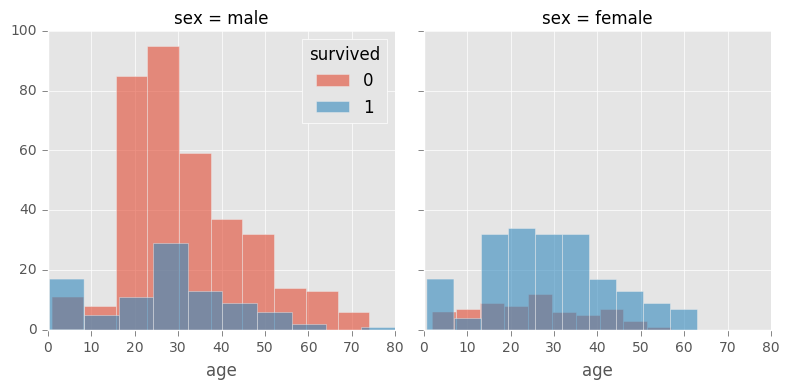

In [5]:
g = sns.FacetGrid(titanic, hue="survived", col="sex", size=4, legend_out=False)
(g.map(plt.hist, "age", alpha=0.6, bins=10)).add_legend()

**Observations**<br>
- There is a massive difference in survival rate for men and women.
- Children younger than 10, were more likely to survive regardless of gender.

### "It's all about the money" - class and ticket price analysis

In [6]:
titanic.pivot_table(values="survived", index="pclass")

,survived
pclass,
1,0.629630
2,0.472826
3,0.242363


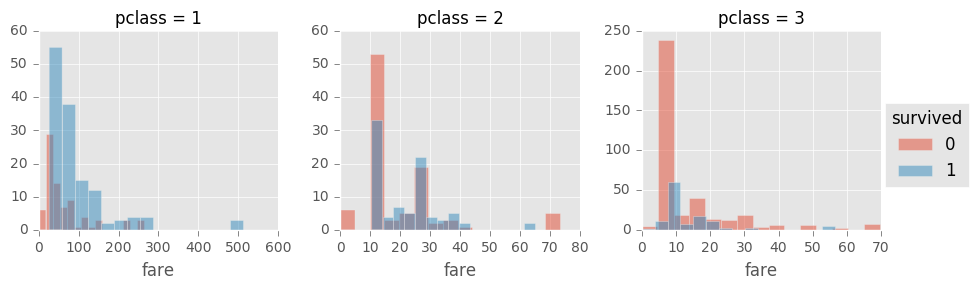

In [7]:
g = sns.FacetGrid(titanic, hue="survived", col="pclass", sharex=False, sharey=False)
g.map(plt.hist, "fare", alpha=0.5, bins=15).add_legend()

**Observation**
- Passengers travelling in higher classes had better chances of survival.
- Paying more for the ticket mattered, but only among the first class passengers.

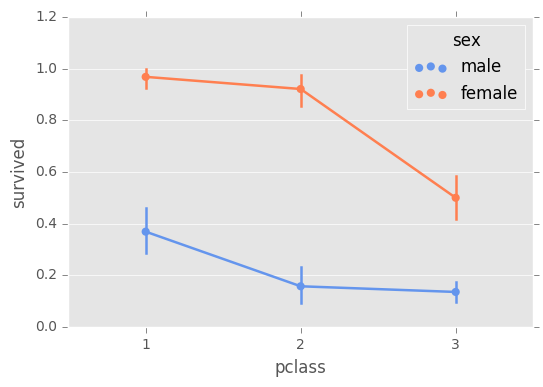

In [8]:
sns.pointplot(data=titanic, x='pclass', y='survived', hue="sex", palette=["cornflowerblue", "coral"])

**Observation**
- Traveling in higher class improved chances for survival, but was not as important as gender.

### "Family first" - how traveling with family members influences survival rate

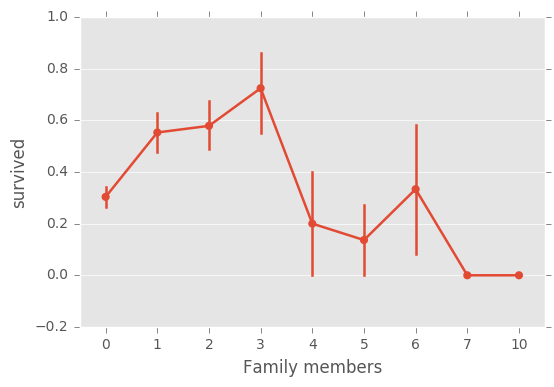

In [9]:
sns.pointplot(data=titanic, x=titanic["parch"] + titanic["sibsp"], y='survived')
plt.xlabel("Family members")

**Observation**
- Travelling with family mattered. People traveling alone and with many relatives aboard had lower survival chance.

### "Location, location, location" - did it matter where a passenger embarked?

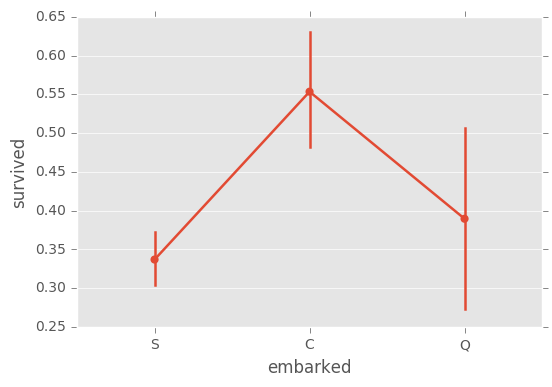

In [10]:
sns.pointplot(data=titanic, x='embarked', y='survived')

**Observation**
- Survival rate varies depending on the town in which the passenger had embarked.

# Data wrangling

In [11]:
titanic = sns.load_dataset("titanic")

In [12]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Few features seem to be conveying the same information but written differently. They can be used to check data integrity and then dropped.

### Dropping features

In [13]:
def drop_duplicate_features(dataset, col_1, col_2, mapping): 
    if (dataset[col_1].map(mapping) == dataset[col_2]).sum() == dataset[col_1].count():
        dataset.drop(col_1, inplace=True, axis=1)
        print("'{}' feature dropped.".format(col_1))

In [14]:
drop_duplicate_features(titanic, 'class', 'pclass', mapping={"Third": 3, "Second": 2, "First": 1})
drop_duplicate_features(titanic, 'embark_town', 'embarked', {x: x[0] for x in titanic.embark_town.dropna().unique()})
drop_duplicate_features(titanic, 'alive', 'survived', {"no": 0, "yes": 1})

'class' feature dropped.
'embark_town' feature dropped.
'alive' feature dropped.


Features 'adult_male' and 'who' can be derived from 'age' and 'sex', which will be included in our model, so they can be dropped.<br>
Same goes for 'alone' which can be derived from 'sibsp' and 'parch'<br>
Feature 'deck' is severely incomplete, and therefore will be dropped.

In [15]:
titanic.drop(['who', 'adult_male'], inplace=True, axis=1)
titanic.drop('alone', inplace=True, axis=1)
titanic.drop('deck', inplace=True, axis=1)

### Feature engineering

Create a feature called "family" that combines siblings and children into one feature.

In [16]:
titanic["family"] = titanic["parch"] + titanic["sibsp"]
titanic["family"] = pd.cut(titanic["family"], bins=[0, 0.5, 3.5, 11], include_lowest=True, 
                           labels=["alone", "small_fam", "big_fam"])
titanic.drop(["sibsp", "parch"], inplace=True, axis=1)

Make feature 'fare' matter only for the first class passengers.

In [17]:
titanic["fare"] = titanic["pclass"].map({1: 1, 2: 0, 3: 0}) * titanic["fare"]

### Filling missing data

In [18]:
titanic["age"] = titanic["age"].fillna(titanic["age"].median())
titanic["embarked"] = titanic["embarked"].fillna(titanic["embarked"].mode().values[0])
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
survived    891 non-null int64
pclass      891 non-null int64
sex         891 non-null object
age         891 non-null float64
fare        891 non-null float64
embarked    891 non-null object
family      891 non-null category
dtypes: category(1), float64(2), int64(2), object(2)
memory usage: 42.8+ KB


### Encoding categorical data

In [19]:
titanic = pd.get_dummies(titanic, columns=['sex', 'embarked', 'family'])

In [20]:
# Standardize numerical data
titanic.loc[:, ['fare', 'age', 'pclass']] = StandardScaler().fit_transform(titanic[['fare', 'age', 'pclass']])

### Scaling numerical data

In [21]:
# Separating data and labels
y = titanic["survived"]
x = titanic.drop("survived", axis=1).values
# Spliting data for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Modeling

**Hypothesis function for logistic regression**

Sigmoid function $ g(z) $ defined as follows: $ g(z)\;=\;\frac1{1+e^{-z}} $ transforms continuous input into range $ y \in \{0, 1\} $

Hypothesis function for logistic regression uses sigmoid function $g(z)$ with $ z $ defined as $ z = \theta^{T}x $. Therefore it is defined as follows: $ h(\theta) = \frac{1}{1 \ + \ e^{\ -\theta^T x}} $
<br>Cost function in logistic regression is defined as: $ Cost \ (h_\theta (x), \ y) = - \ y \ log(h_\theta (x)) \ - \ (1 - y) \ log(1 - h_\theta (x)) $

Or, in vectorized version: $ J(\theta)=-\frac1m\cdot\big(-y^T\log(h)-(1-y)^T\log(1-h)\big) $
<br>With vectorized implementation of gradient descent: $ \theta \ := \theta-\frac{\alpha}{m}X^T\big(g(X\theta)-{y}\big)$

**Numpy implementation**

For benchmark let's take score from scikit-learn implementation of Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
model_sklearn = LogisticRegression()
model_sklearn.fit(X_train, y_train)
benchmark = model_sklearn.score(X_test, y_test)
benchmark

0.80970149253731338

Logistic Regression implementation using NumPy

In [23]:
class LogRegNP(object):
    
    def __init__(self, iterations=100, learning_rate=0.01, lambd=1, add_intercept=True):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.lambd = lambd
        self.add_intercept = add_intercept
        self.x, self.y, self.w = None, None, None
        self.costs = []
    
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.e ** - z)
        
    def hypothesis(self, data=None):
        if data is None:
            data = self.x
        return self.sigmoid(data @ self.w)
        
    def cost(self):
        n_samples = self.x.shape[1]
        first_term = -self.y.T @ np.log(self.hypothesis())
        second_term = (1 - self.y).T @ np.log(1 - self.hypothesis())
        return ((1 / n_samples) * (first_term - second_term)).ravel()[0]
        
    def set_data(self, x, y):
        if self.add_intercept == True:
            self.x = np.insert(x, 0, 1, axis=1)
        self.y = y.as_matrix().reshape(len(y), 1)
        if self.w is None:
            self.w = np.ones((self.x.shape[1], 1))
                
    def fit(self, x, y):
        self.set_data(x, y)
        n_samples = self.x.shape[1]
        
        for _ in range(self.iterations):
            self.w = self.w - (self.learning_rate / n_samples) * (self.x.T @ (self.hypothesis() - self.y) + self.lambd * np.sum(self.w))
            self.costs.append(self.cost())
                
    def plot_costs(self):
        plt.plot(self.costs)
        
    def score(self, x_data, y_data):
        if self.add_intercept == True:
            x_data = np.insert(x_data, 0, 1, axis=1)
        y_data = y_data.as_matrix().reshape(len(y_data), 1)
        predictions = (self.hypothesis(data=x_data) > 0.5)
        true_predictions = predictions == y_data
        
        return np.sum(true_predictions) / len(predictions)

In [24]:
model_numpy = LogRegNP(iterations=50, learning_rate=0.03)
model_numpy.fit(X_train, y_train)
score_np = model_numpy.score(X_test, y_test)
print("Model's score: ", score_np, "\nDifference between model's score and benchmark: ", score_np - benchmark)

Model's score:  0.809701492537 
Difference between model's score and benchmark:  0.0


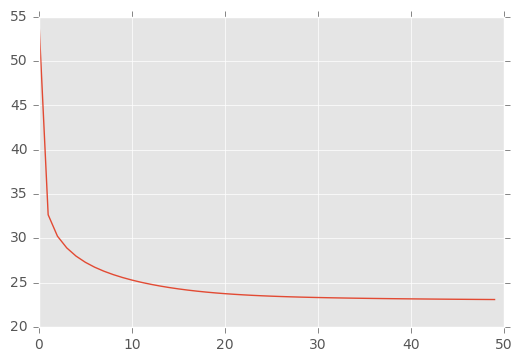

In [25]:
model_numpy.plot_costs()

**Tensorflow implementation**

Functions for visualizing tensorflow graphs, useful for debugging

In [26]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def

def show_graph(graph_def=tf.get_default_graph(), max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [27]:
class LogRegTF(object):
    
    def __init__(self, iterations=100, learning_rate=0.01, lambd=1, add_intercept=True):
        tf.reset_default_graph()
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.lambd = lambd
        self.add_intercept = add_intercept
        self.X = tf.placeholder(dtype="float32", name="X")
        self.Y = tf.placeholder(dtype="float32", name="Y")
        self.w = None
        self.costs = []
    
    @staticmethod
    def sigmoid(vector):
        return 1 / (1 + np.e ** - vector)
        
    def hypothesis(self, data=None, w=None):
        if data is None:
            data = self.X
        if w is None:
            w = self.w
        return self.sigmoid(data @ w)
    
    def cost(self):
        n_samples = self.x.shape[1]
        first_term = tf.matmul(-self.Y, tf.log(self.hypothesis()), transpose_a=True)
        second_term = tf.matmul(1 - self.Y, tf.log(1 - self.hypothesis()), transpose_a=True)
        return ((1 / n_samples) * (first_term - second_term - tf.reduce_sum(self.w)))
    
    def set_data(self, x, y):
        if self.add_intercept == True:
            self.x = np.insert(x, 0, 1, axis=1)
        self.y = y.as_matrix().reshape(len(y), 1)
        if self.w is None:
            self.w = tf.Variable(tf.ones((self.x.shape[1], 1)), dtype="float32")
                
    def fit(self, x, y):
        self.set_data(x, y)
        
        opt = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
        goal = opt.minimize(self.cost())
        
        with tf.Session() as sess:
            print("Session Started")
            sess.run(tf.global_variables_initializer())
            for i in range(self.iterations):
                results = sess.run([goal, self.cost(), self.w], feed_dict={self.X: self.x, self.Y: self.y})
                # Store current cost function value
                self.costs.append(results[1][0])
            # Store optimized parameters vector
            self.last_w = results[2]
                
    def plot_costs(self):
        plt.plot([x[0] for x in self.costs])
       
    def score(self, x_data, y_data):
        if self.add_intercept == True:
            x_data = np.insert(x_data, 0, 1, axis=1)
        y_data = y_data.as_matrix().reshape(len(y_data), 1)
        predictions = (self.hypothesis(data=x_data, w=self.last_w) > 0.5).astype("int") == y_data
        return np.sum(predictions) / len(predictions)

In [28]:
model_tf = LogRegTF(iterations=50, learning_rate=0.03)
model_tf.fit(X_train, y_train)
score_tf = model_tf.score(X_test, y_test)
print("Model's score: ", score_tf, "\nDifference between model's score and benchmark: ", score_tf - benchmark)

Session Started
Model's score:  0.809701492537 
Difference between model's score and benchmark:  0.0


In [29]:
show_graph(tf.get_default_graph())

In [30]:
class LogRegTFlean(object):
    
    def __init__(self, iterations=100, learning_rate=0.03, lambd=1, add_intercept=True):
        tf.reset_default_graph()
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.lambd = lambd
        self.add_intercept = add_intercept
        self.X = tf.placeholder(dtype="float32", name="X")
        self.Y = tf.placeholder(dtype="float32", name="Y")
        self.w = None
        self.costs = []
    
    @staticmethod
    def sigmoid(vector):
        return 1 / (1 + np.e ** - vector)
        
    def hypothesis(self, data=None, w=None):
        if data is None:
            data = self.X
        if w is None:
            w = self.w
        return self.sigmoid(data @ w)

    def cost(self):
        n_samples = self.x.shape[1]
        first_term = tf.matmul(-tf.transpose(self.Y), tf.log(self.hypothesis()))
        second_term = tf.matmul(tf.transpose(1 - self.Y), tf.log(1 - self.hypothesis()))
        return ((1 / n_samples) * (first_term - second_term - tf.reduce_sum(self.w)))        
    
    def set_data(self, x, y):
        if self.add_intercept == True:
            self.x = np.insert(x, 0, 1, axis=1)
        self.y = y.as_matrix().reshape(len(y), 1)
        if self.w is None:
            self.w = tf.ones((self.x.shape[1], 1), dtype=tf.float32, name="w")
                
    def fit(self, x, y):
        self.set_data(x, y)
        n_samples = self.x.shape[1]
        
        with tf.Session() as sess:
            print("Session started")
            for _ in range(self.iterations):
                # Gradient descent
                self.w = self.w - (self.learning_rate / n_samples) \
                         * (tf.matmul(self.X, (self.hypothesis() - self.Y), transpose_a=True) + self.lambd * tf.reduce_sum(self.w))
            # Store optimized parameters for model's predictions
            self.last_w = sess.run(self.w, feed_dict={self.X: self.x, self.Y: self.y})
                
    def plot_costs(self):
        plt.plot([x[0] for x in self.costs])
       
    def score(self, x_data, y_data):
        if self.add_intercept == True:
            x_data = np.insert(x_data, 0, 1, axis=1)
        y_data = y_data.as_matrix().reshape(len(y_data), 1)
        predictions = (self.hypothesis(data=x_data, w=self.last_w) > 0.5).astype("int") == y_data
        return np.sum(predictions) / len(predictions)

In [31]:
model_tfl = LogRegTFlean(iterations=50, learning_rate=0.03)
model_tfl.fit(X_train, y_train)
score_tfl = model_tfl.score(X_test, y_test)
print("Model's score: ", score_tfl, "\nDifference between model's score and benchmark: ", score_tfl - benchmark)

Session started
Model's score:  0.809701492537 
Difference between model's score and benchmark:  0.0


In [32]:
show_graph(tf.get_default_graph())